In [1]:
# Import libraries
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import json
from typing import Union
import numpy as np
from disagreement import Disagreement
import itertools
import joblib

In [2]:
from compactor.MaxNonActivatedCompactor import MaxNonActivatedCompactor
from compactor.ActivatedCompactor import ActivatedCompactor
from compactor.MaxCompactor import MaxCompactor

In [3]:
root = "/storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/new/model_outputs/"
model_path = "random_forest_t_1000_md_10/" # Change
model_name = "random_forest_t_1000_md_10_fold_1_2016-01-07.sav" # Change
xai_root = root + "xai/2024/"
art_root = root + "artifacts/"
analysis_path = root + "analysis/2024/" #Change
json_file_path = xai_root + model_path + "all_exp.json"
baseline_json_file_path =  xai_root + model_path + "baseline/all_exp.json"

predictions_file_path = art_root + model_path + "test_prediction_fold_1_2016-01-07.csv" # Change
processed_data_path = "/storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/processed_data/processed_final_data_latest.csv"

fold = 'fold1' 
n_features_compressed = None
top_10_perc_uncompressed = None
model_type = 'rf' # Types: nn, xgb, lgbm, lr, rf # Change

save_path = analysis_path + model_path + f"disagreement_baseline/{fold}/"

In [4]:
create_nocomp = True
create_max = True
create_act = True
create_maxnonact = True

In [5]:
# Change directory and import
os.chdir("/storage/scratch/e17-fyp-xai/projects/mad_v3/e17-4yp-using-machine-learning-in-high-stake-settings/code/")
import config
categorical_cols = config.CATEGORICAL_COLS

In [24]:
!ls /storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/

config.py		   model_outputs_5
data			   model_outputs_6
data_processer.ipynb	   model_outputs_8
data_processor.py	   model_parameters
eda.py			   nohup.out
environment.yml		   processed_data
Feature_Engineering.ipynb  processed_final_data_latest.csv
Feature_Engineering.py	   __pycache__
feature_engineer.py	   README.md
helper.py		   requirements.txt
kernelshap_explainer.py    run_explanations.py
lime_explainer.py	   Sanity_checks.ipynb
main.py			   temporal_features.py
model_outputs		   trained_models
model_outputs_10	   treeshap_explainer.py
model_outputs_13	   Untitled.ipynb
model_outputs_2		   xai_results
model_outputs_3		   xai_test_results
model_outputs_4


In [6]:
# Helper functions
# Function to save images
def save_image(caption, path):
    set_path = f'{path}/{caption}.png'
    plt.savefig(set_path)

def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
make_directory(save_path)

In [7]:
# Load predictions - To get the predicted label
predictions = pd.read_csv(predictions_file_path)
predictions.head()

,Unnamed: 0,Project ID,1,Start Date
0,34,d8cfc7857397d7ae2ebb22dc26bfdb6e,0.445872,2016-01-07
1,52,dfc090d2fd5be84f7f6a24bea5d2790d,0.346720,2016-01-07
2,65,e9ad2c8eebe8572a84cec5ae73295265,0.267832,2016-01-07
3,88,3d38e90c9b5e1d64307b6bd005242bcd,0.541232,2016-01-07
4,91,954a9ecb81da087c9171ae152133e19d,0.305244,2016-01-07


In [8]:
# Read dataframe to get actual label and for the categorical columns
processed = pd.read_csv(processed_data_path)
processed.columns

Index(['Unnamed: 0', 'Project ID', 'Project Posted Date', 'Project Type',
       'Project Posted Month', 'Project Subject Category Tree', 'Project Cost',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'School Metro Type', 'School State',
       'Teacher Project Posted Sequence', 'Label', 'Teacher Success Rate',
       'Teacher Success Rate Imputed', 'School City Success Rate',
       'School City Success Rate Imputed', 'School Success Rate',
       'School Success Rate Imputed', 'School County Success Rate',
       'School County Success Rate Imputed', 'Project Count in State',
       'Project Need Statement Length', 'School City',
       'Project Need Statement', 'Resource Vendor Name', 'Teacher Prefix',
       'Project Short Description Length', 'School County',
       'Project Count in County', 'Project Title', 'Project Essay',
       'Resource Cost Percentage', 'Project Essay Length',
       'School Percentage Free Lun

In [9]:
# Load explanations
explanations = json.load(open(json_file_path))
explanations_baseline = json.load(open(baseline_json_file_path))

In [10]:
# Set n features values
top_10_perc_uncompressed = 61
n_features_compressed = 31

In [11]:
xai_keys = list(explanations[fold].keys())
# Reconstruct baseline dictionary
explanations_baseline_combined = {
    fold: {}
}

for key in xai_keys:
    explanations_baseline_combined[fold][key] = explanations_baseline[fold][key]["top"] | explanations_baseline[fold][key]["bottom"]

print(len(explanations_baseline_combined[fold][xai_keys[0]]))
print(len(explanations[fold][xai_keys[0]]['top']))

6000
500


Calculating the average disagreement

1. LIME vs SHAP

In [12]:
def disagreement_average(explanations1: dict , explanations2: dict , k: int, features_F: list , method = None, raw_data = None, debug = False) -> dict:
    
    disagreement_mean = {'feature_agreement': 0.0,
                         'rank_agreement': 0.0,
                         'sign_agreement': 0.0,
                         'signed_rank_agreement': 0.0}
    
    for project_id in explanations1.keys():
        if debug:
            print(f"******************Project ID: {project_id}************************")
        
        if len(explanations1[project_id]) < k:
            raise ValueError(f"K should be less than {len(explanations1[project_id])}")
        
        disagreement_calc_2 = Disagreement(explanations1[project_id], explanations2[project_id])
        
        if debug:
            print("Initial Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("Initial Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
        if method=="max":
            max_compactor = MaxCompactor(categorical_cols)
            disagreement_calc_2.compact_features(max_compactor)
            
            
        elif method == "activated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            activated_compactor = ActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(activated_compactor)
            
        elif method == "maxnonactivated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            max_non_activated_compactor = MaxNonActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(max_non_activated_compactor)
            
        if debug:
            print("After Compact Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("After Compact Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
            
        disagreement = disagreement_calc_2.get_disagreement(k, features_F)
        
        if debug:
            print("Disagreement : ", disagreement)
        
        for key in list(disagreement_mean.keys()):
            if disagreement[key] == None:
                raise ValueError(f"The value for key '{key}' in disagreement_mean is None.")
            disagreement_mean[key] += disagreement[key]
        
        if debug:
            print("****************************************")

    for key in list(disagreement_mean.keys()):
        disagreement_mean[key] = round(disagreement_mean[key] / len(explanations1.keys()),3)
    
    if debug:
        print("*********************************************")
        print(disagreement_mean)
        print("*********************************************")

    
    return disagreement_mean

In [13]:
def disagreement_for_exp_dict(explanations, baseline_explanations, exp_name_1, exp_name_2, k_range, method=None, raw_data=None, debug=False):

    # For top list
    disagreement_mean_across_top = {'feature_agreement': [],
                                    'rank_agreement': [],
                                    'sign_agreement': [],
                                    'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_top_comparison = disagreement_average(explanations[fold][exp_name_1]["top"], explanations[fold][exp_name_2]["top"], i, None, method, raw_data, debug)

        for key in list(disagreement_mean_across_top.keys()):
            disagreement_mean_across_top[key].append(explanations_top_comparison[key])

    # For bottom list
    disagreement_mean_across_bottom = {'feature_agreement': [],
                                       'rank_agreement': [],
                                       'sign_agreement': [],
                                       'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_bottom_comparison = disagreement_average(explanations[fold][exp_name_1]["bottom"], explanations[fold][exp_name_2]["bottom"], i, None, method, raw_data, debug)

        for key in list(disagreement_mean_across_bottom.keys()):
            disagreement_mean_across_bottom[key].append(explanations_bottom_comparison[key])


    # For baseline
    disagreement_mean_across_baseline = {'feature_agreement': [],
                                         'rank_agreement': [],
                                         'sign_agreement': [],
                                         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_baseline = disagreement_average(baseline_explanations[fold][exp_name_1], baseline_explanations[fold][exp_name_2], i, None, method, raw_data, debug)

        for key in list(disagreement_mean_across_baseline.keys()):
            disagreement_mean_across_baseline[key].append(explanations_baseline[key])

    return disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_average_across_n_projects_various_k_features(disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline, feature_n, caption, key_1, key_2, type):

    feature_range = range(1, feature_n+1, 1)

    # Create separate subplots for each agreement metric
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))

    # Plot Feature Agreement for top k
    axs[0].plot(feature_range, disagreement_mean_across_top["feature_agreement"], label='Feature Agreement (Top Projects)', marker='o', color='b')
    axs[0].plot(feature_range, disagreement_mean_across_bottom["feature_agreement"], label='Feature Agreement (Bottom Projects)', linestyle='--', marker='o', color='r')
    axs[0].plot(feature_range, disagreement_mean_across_baseline["feature_agreement"], label='Feature Agreement (Baseline)', marker='o', color='#ee82ee')
    axs[0].set_xlabel('Number of Features (Top K)')
    axs[0].set_ylabel('Agreement Score')
    axs[0].set_title('Feature Agreement vs. Number of Features (Top K)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Rank Agreement for top k
    axs[1].plot(feature_range, disagreement_mean_across_top["rank_agreement"], label='Rank Agreement (Top Projects)', marker='s', color='g')
    axs[1].plot(feature_range, disagreement_mean_across_bottom["rank_agreement"], label='Rank Agreement (Bottom Projects)', linestyle='--', marker='s', color='m')
    axs[1].plot(feature_range, disagreement_mean_across_baseline["rank_agreement"], label='Rank Agreement (Baseline)', marker='s', color='#3cb371')
    axs[1].set_xlabel('Number of Features (Top K)')
    axs[1].set_ylabel('Agreement Score')
    axs[1].set_title('Rank Agreement vs. Number of Features (Top K)')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Sign Agreement for top k
    axs[2].plot(feature_range, disagreement_mean_across_top["sign_agreement"], label='Sign Agreement (Top Projects)', marker='^', color='c')
    axs[2].plot(feature_range, disagreement_mean_across_bottom["sign_agreement"], label='Sign Agreement (Bottom Projects)', linestyle='--', marker='^', color='y')
    axs[2].plot(feature_range, disagreement_mean_across_baseline["sign_agreement"], label='Sign Agreement (Baseline)', marker='^', color='#ff6347')
    axs[2].set_xlabel('Number of Features (Top K)')
    axs[2].set_ylabel('Agreement Score')
    axs[2].set_title('Sign Agreement vs. Number of Features (Top K)')
    axs[2].legend()
    axs[2].grid(True)

    # Plot Signed Rank Agreement for top k
    axs[3].plot(feature_range, disagreement_mean_across_top["signed_rank_agreement"], label='Signed Rank Agreement (Top Projects)', marker='x', color='k')
    axs[3].plot(feature_range, disagreement_mean_across_bottom["signed_rank_agreement"], label='Signed Rank Agreement (Bottom Projects)', linestyle='--', marker='x', color='orange')
    axs[3].plot(feature_range, disagreement_mean_across_baseline["signed_rank_agreement"], label='Signed Rank Agreement (Baseline)', marker='x', color='#463505')
    axs[3].set_xlabel('Number of Features (Top K)')
    axs[3].set_ylabel('Agreement Score')
    axs[3].set_title('Signed Rank Agreement vs. Number of Features (Top K)')
    axs[3].legend()
    axs[3].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    save_image(caption, save_path)
    plt.show()

Local vs local

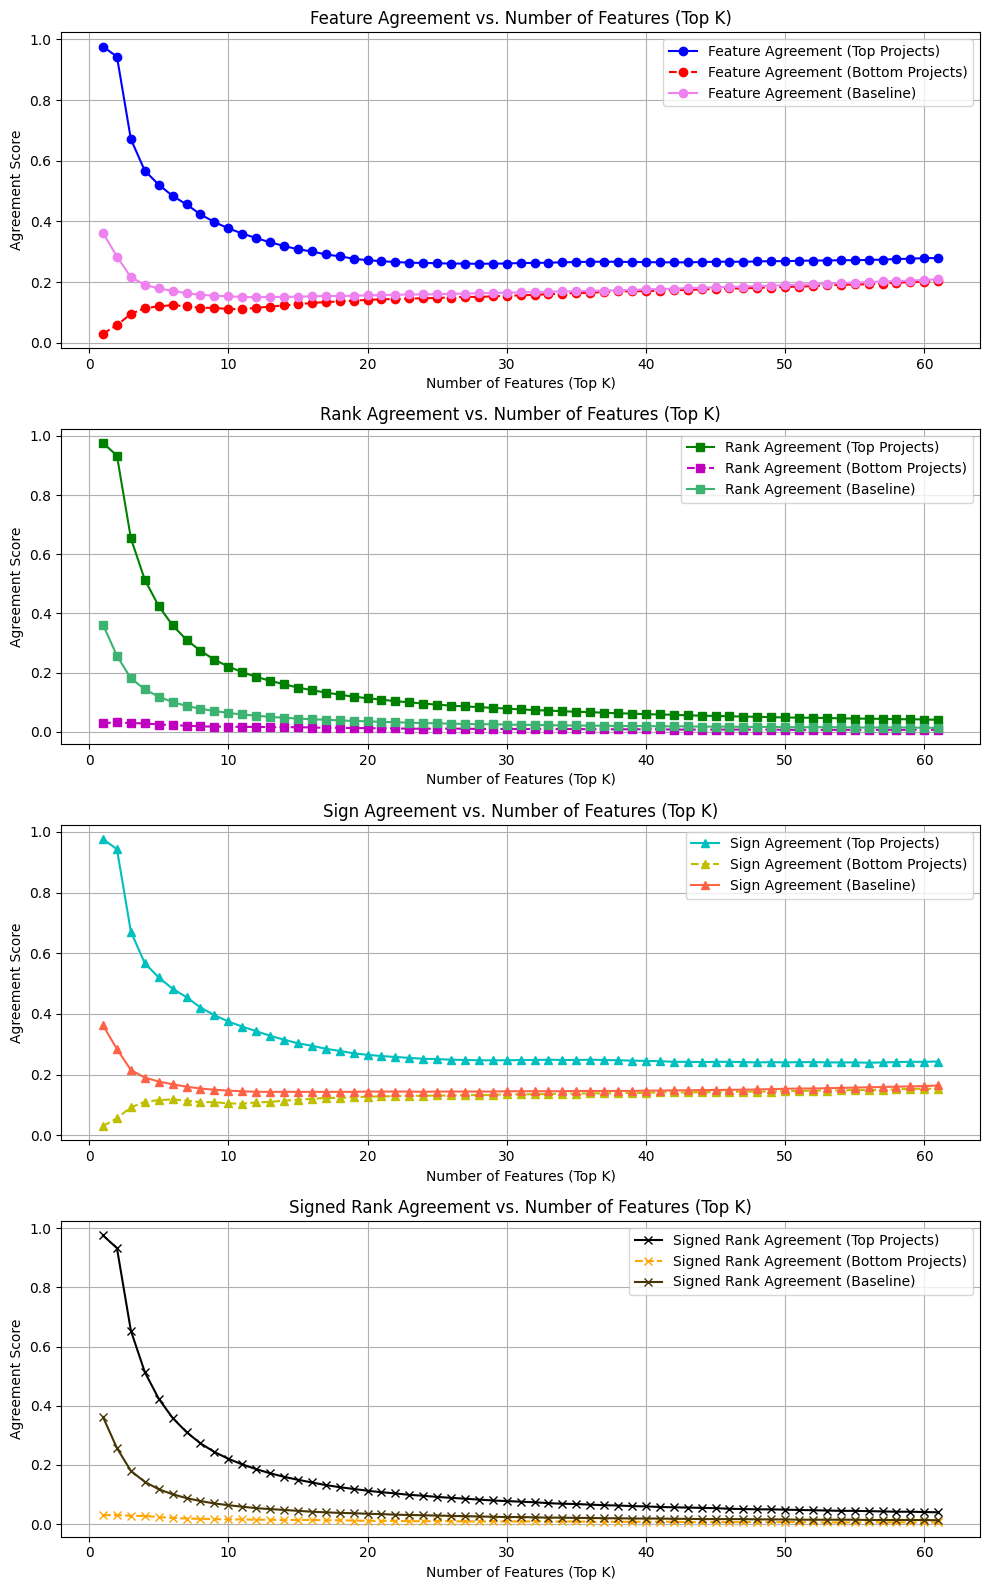

KeyboardInterrupt: 

In [21]:
# Find the diasgreement among all local explanations
for key_pair in list(itertools.combinations(xai_keys, 2)):
    # Top 10% with no compactor
    if create_nocomp:
        dm_top_no_comp_10 , dm_bottom_no_comp_10, dm_base_no_comp_10 =  disagreement_for_exp_dict(explanations, explanations_baseline_combined, key_pair[0], key_pair[1], top_10_perc_uncompressed)
        plot_no_comp_10_perc_name = f"{key_pair[0]}_vs_{key_pair[1]}_10%_no_comp_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_no_comp_10 , dm_bottom_no_comp_10, dm_base_no_comp_10, top_10_perc_uncompressed, plot_no_comp_10_perc_name, key_pair[0], key_pair[1], "no compactor mode")

    # For max compactor - compressed set of features
    if create_max:
        # explanations, baseline_explanations, exp_name_1, exp_name_2, k_range, method=None, raw_data=None, debug=False
        dm_top_max , dm_bottom_max, dm_base_max =  disagreement_for_exp_dict(explanations, explanations_baseline_combined, key_pair[0], key_pair[1], n_features_compressed, "max", processed)
        plot_max_name = f"{key_pair[0]}_vs_{key_pair[1]}_max_comp_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_max , dm_bottom_max, dm_base_max, n_features_compressed, plot_max_name, key_pair[0], key_pair[1], "max compactor mode")

    # For activated compactor
    if create_act:
        dm_top_act, dm_bottom_act, dm_base_act =  disagreement_for_exp_dict(explanations, explanations_baseline_combined, key_pair[0], key_pair[1], n_features_compressed, "activated", processed)
        plot_act_name = f"{key_pair[0]}_vs_{key_pair[1]}_act_comp_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_act, dm_bottom_act, dm_base_act, n_features_compressed, plot_act_name, key_pair[0], key_pair[1], "activated compactor mode")

    # For max nonactivated compactor
    if create_maxnonact:
        dm_top_maxnonact, dm_bottom_maxnonact, dm_base_maxnonact = disagreement_for_exp_dict(explanations, explanations_baseline_combined, key_pair[0], key_pair[1], n_features_compressed, "maxnonactivated", processed)
        plot_maxnonact_name = f"{key_pair[0]}_vs_{key_pair[1]}_maxnonact_comp_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_maxnonact, dm_bottom_maxnonact, dm_base_maxnonact, n_features_compressed, plot_maxnonact_name, key_pair[0], key_pair[1], "maxnonactivated compactor mode")
        

Local vs Global 

In [13]:
# Function to load the pickle file and return the feature importances
def load_model_and_feat(model_path, model_name, model_type):
    # Load the model
    model = None
    importance = None
    feat_names = None
    
    if model_type == 'nn':
        model_file_path = f'{model_path}{model_name}' 
        model = keras.models.load_model(model_file_path)
        # Skip the rest

    elif model_type == 'lgbm':
        model_file_path = f'{model_path}{model_name}'
        model = joblib.load(model_file_path)
        # Load the feature importance array
        importance = model.feature_importances_
        # Get the feature names
        feat_names = model.feature_name_

    elif model_type == 'lr':
        model_file_path = f'{model_path}{model_name}'
        model = joblib.load(model_file_path)
        # Load the feature importance array
        importance = model.coef_[0]
        # Get the feature names
        feat_names = model.feature_names_in_
    
    else:
        model_file_path = f'{model_path}{model_name}'
        model = joblib.load(model_file_path)
        # Load the feature importance array
        importance = model.feature_importances_
        # Get the feature names
        feat_names = model.feature_names_in_
    
    return importance, feat_names


# Function to sort features and output
def sort_features(importance, feat_names):
    # Create df and sort
    df = pd.DataFrame({"Feature": feat_names, "Importance": importance})
    #df_sorted = df.sort_values("Importance", ascending=False)
    df_sorted = df.reindex(df.Importance.abs().sort_values(ascending=False).index)
    return df_sorted

In [14]:
def disagreement_average_global_vs_local(global_exp: dict , local_exp: dict , k: int, features_F: list , method = None, raw_data = None, debug = False) -> dict:
    
    disagreement_mean = {'feature_agreement': 0.0,
                         'rank_agreement': 0.0,
                         'sign_agreement': 0.0,
                         'signed_rank_agreement': 0.0}
    
    for project_id in local_exp.keys():
        if debug:
            print(f"******************Project ID: {project_id}************************")
        
        if len(local_exp[project_id]) < k:
            raise ValueError(f"K should be less than {len(local_exp[project_id])}")
        
        disagreement_calc_2 = Disagreement(global_exp, local_exp[project_id])
        
        if debug:
            print("Initial Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("Initial Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
        if method=="max":
            max_compactor = MaxCompactor(categorical_cols)
            disagreement_calc_2.compact_features(max_compactor)

        elif method == "activated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            activated_compactor = ActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(activated_compactor)
            
        elif method == "maxnonactivated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            max_non_activated_compactor = MaxNonActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(max_non_activated_compactor)
            
        if debug:
            print("After Compact Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("After Compact Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
            
        disagreement = disagreement_calc_2.get_disagreement(k, features_F)

        if debug:
            print("Disagreement : ", disagreement)
        
        for key in list(disagreement_mean.keys()):
            if disagreement[key] == None:
                raise ValueError(f"The value for key '{key}' in disagreement_mean is None.")
            disagreement_mean[key] += disagreement[key]
        
        if debug:
            print("****************************************")

    for key in list(disagreement_mean.keys()):
        disagreement_mean[key] = round(disagreement_mean[key] / len(local_exp.keys()),3)
    
    if debug:
        print("*********************************************")
        print(disagreement_mean)
        print("*********************************************")

    
    return disagreement_mean

In [15]:
def disagreement_for_exp_dict_global_vs_local(global_explanations, explanations, explanations_baseline, local_exp_name, k_range, method=None, raw_data=None):

    # Explanations for top projects
    disagreement_mean_across_top = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_global_vs_local_top = disagreement_average_global_vs_local(global_explanations, explanations[fold][local_exp_name]["top"], i, None, method, raw_data)

        for key in list(disagreement_mean_across_top.keys()):
            disagreement_mean_across_top[key].append(explanations_global_vs_local_top[key])

    # Explanations for bottom projects
    disagreement_mean_across_bottom = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_global_vs_local_bottom = disagreement_average_global_vs_local(global_explanations, explanations[fold][local_exp_name]["bottom"], i, None, method, raw_data)

        for key in list(disagreement_mean_across_bottom.keys()):
            disagreement_mean_across_bottom[key].append(explanations_global_vs_local_bottom[key])


    # Explanations for baseline projects
    disagreement_mean_across_baseline = {'feature_agreement': [],
         'rank_agreement': [],
         'sign_agreement': [],
         'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_global_vs_local_baseline = disagreement_average_global_vs_local(global_explanations, explanations_baseline[fold][local_exp_name], i, None, method, raw_data)

        for key in list(disagreement_mean_across_baseline.keys()):
            disagreement_mean_across_baseline[key].append(explanations_global_vs_local_baseline[key])

    return disagreement_mean_across_top, disagreement_mean_across_bottom, disagreement_mean_across_baseline


In [16]:
# Load the pickle file and get global feature importance
global_importance, feat_names = load_model_and_feat(art_root+model_path, model_name, model_type)
#print(global_importance, feat_names)
global_explanation = sort_features(global_importance, feat_names)
global_explanation.values

array([['Project Cost', 0.21832490517874864],
       ['Resource Cost', 0.10584395574442541],
       ['School Success Rate', 0.06696661597145076],
       ...,
       ['Project Subject Subcategory Tree_Special Needs, Warmth, Care & Hunger',
        0.0],
       ['Project Subject Subcategory Tree_Team Sports, Visual Arts', 0.0],
       ['Project Subject Subcategory Tree_Gym & Fitness, Warmth, Care & Hunger',
        0.0]], dtype=object)

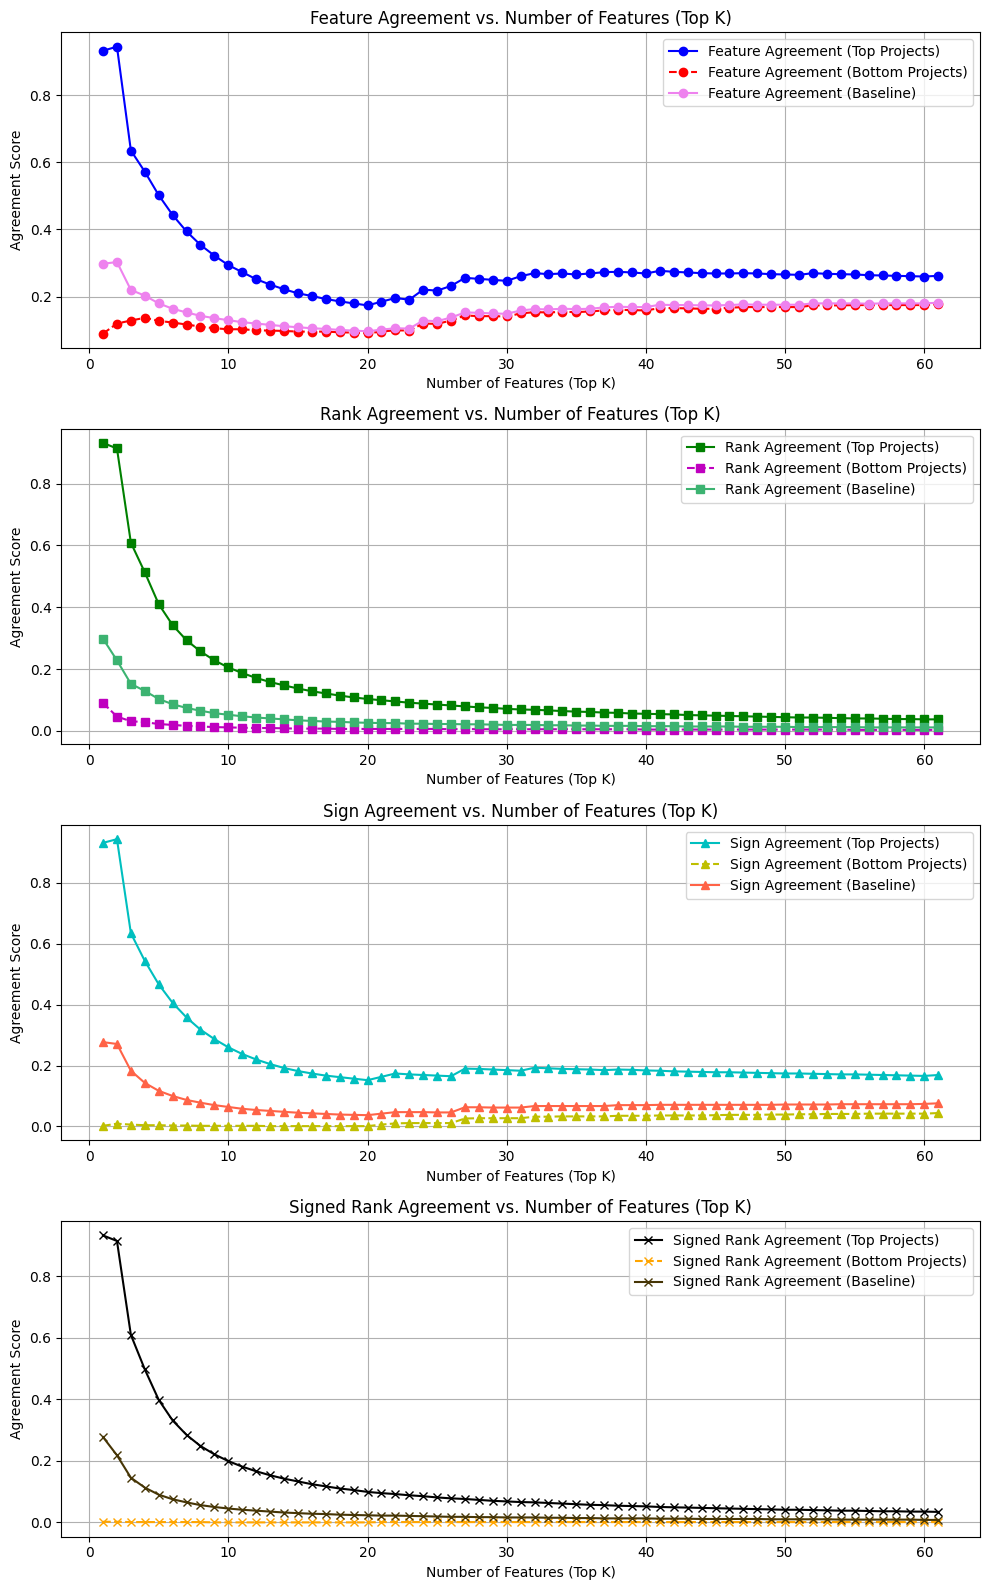

KeyboardInterrupt: 

In [17]:
# For global vs local
for local_key in xai_keys:
    # Top 10% with no compactor
    if create_nocomp:
        #global_explanations, explanations, explanations_baseline, local_exp_name, k_range, method=None, raw_data=None
        dm_top_no_comp_10_perc, dm_bottom_no_comp_10_perc, dm_baseline_no_comp_10_perc = disagreement_for_exp_dict_global_vs_local(global_explanation.values, explanations, explanations_baseline_combined, local_key, top_10_perc_uncompressed)
        plot_no_comp_10_perc_name = f"Global_vs_{local_key}_10%_no_comp_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_no_comp_10_perc, dm_bottom_no_comp_10_perc, dm_baseline_no_comp_10_perc, top_10_perc_uncompressed, plot_no_comp_10_perc_name, "global", local_key, "no compactor mode")

    # Max compactor
    if create_max:
        dm_top_max, dm_bottom_max, dm_baseline_max = disagreement_for_exp_dict_global_vs_local(global_explanation.values, explanations, explanations_baseline_combined, local_key, n_features_compressed, 'max', processed)
        plot_max_name = f"Global_vs_{local_key}_max_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_max, dm_bottom_max, dm_baseline_max, n_features_compressed, plot_max_name, "global", local_key, "max compactor mode")

    # Activated compactor
    if create_act:
        dm_top_act, dm_bottom_act, dm_baseline_act = disagreement_for_exp_dict_global_vs_local(global_explanation.values, explanations, explanations_baseline_combined, local_key, n_features_compressed, 'activated', processed)
        plot_act_name = f"Global_vs_{local_key}_activated_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_act, dm_bottom_act, dm_baseline_act, n_features_compressed, plot_act_name, "global", local_key, "activated compactor mode")

    # Max nonactivated compactor
    if create_maxnonact:
        dm_top_maxnonact, dm_bottom_maxnonact, dm_baseline_maxnonact = disagreement_for_exp_dict_global_vs_local(global_explanation.values, explanations, explanations_baseline_combined, local_key, n_features_compressed, 'activated', processed)
        plot_maxnonact_name = f"Global_vs_{local_key}_maxnonactivated_baseline"
        plot_average_across_n_projects_various_k_features(dm_top_maxnonact, dm_bottom_maxnonact, dm_baseline_maxnonact, n_features_compressed, plot_maxnonact_name, "global", local_key, "maxactivated compactor mode")
    